# 7 Probabiities of Default (PD): Continuous Time Hazard Models

In this chapter, we estimate continuous-time hazard models. These models describe the survival time. We show how to compute
survival probabilities and default probabilities in a second stage. 
We begin by importing the necesary libraries.

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import lifelines as ll
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter
import math

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\parentpoller.py:116: UserWarning: Parent poll failed.  If the frontend dies,
                the kernel may be left running.  Please let us know
                about your system (bitness, Python, etc.) at
                ipython-dev@scipy.org
  ipython-dev@scipy.org""")


In [5]:
import scipy.stats as stats
import sklearn
import seaborn as sns; sns.set()
from statsmodels.stats.weightstats import ttest_ind
import numpy.matlib 
import random
from scipy import stats
from scipy.stats import ttest_ind
import csv
import mord as m
import Mord_CRA as cra

Install nbextensions to activate table of contents from home tab Nbextensions 

In [6]:
# !pip install jupyter_contrib_nbextensions && jupyter contrib nbextension install 

In [7]:
# np.set_printoptions(precision=25)

Read data sets and install required packages. This step can be skipped if the data set has been imported in the current session or the package has been installed before:

In [9]:
mortgage = pd.read_csv("mortgage.csv")  

 # Actuarial Method
 ## Reshaping the Data
 Create a copy of the data set *mortgage*, name it as *lifetest_temp2* ,and sort it by *id*.

In [10]:
lifetest_temp1 = mortgage

In [11]:
lifetest_temp1 = lifetest_temp1.sort_values(['id'],ascending=[1])

 Generate new variable *time2*.

In [12]:
lifetest_temp1['time2'] = (lifetest_temp1.time - lifetest_temp1.first_time + 1)
lifetest_temp1.sort_values(['id','time2'], ascending=True, inplace=True)

Generate new variable *indicator* with values of 0. Then use function *which()* to retrieve the row reference number of the last observation for each value *id*. Fianlly, assign values of 1 to *indicator* when that row is a last observation.

If there are any duplicates, function *duplicated()* with argument *fromLast=TRUE* will retrieve the reference number of all duplicated elements except for the last identical elements. Then function *!duplicated(lifetest_temp1$id, fromLast=T)* will only keep the last identical elements and non-duplicated elements, which is equivalent to the last observations.


In [13]:
lifetest_temp1['indicator'] = 0

In [14]:
temp_ref = np.array(np.where([lifetest_temp1.id.duplicated(keep='last')==False])[1])

In [15]:
lifetest_temp1.loc[temp_ref,'indicator'] = 1

 Create a subset of *lifetest_temp1* with condition of both *indicator* and *default_time* are 1. Name it as *lifetest_temp2*.

In [16]:
lifetest_temp2 = lifetest_temp1[(lifetest_temp1.indicator == 1) | (lifetest_temp1.default_time == 1)]   

Use function *which()* to retrieve the row reference number of the first observation for each value of *id*. Then create a subset of *lifetest_temp2* with these row reference numbers and name it as *lifetest*.

In [17]:
temp_ref = np.where([lifetest_temp2.id.duplicated(keep='first')==False])[1]

In [18]:
lifetest = lifetest_temp2.iloc[temp_ref]

Generate output with selected variables (columns) and id values.
  
----sample output-------------------------------------------------------

**Exhibit 7.4**

In [19]:
variables = {'id', 'first_time', 'time2','default_time','payoff_time','FICO_orig_time','LTV_orig_time'}
sliced_lifetest = lifetest.loc[:,variables] 
list_of_values = [46,47,56]
sliced_lifetest= sliced_lifetest.query("id in @list_of_values")
print(sliced_lifetest.to_string())

     default_time  time2  payoff_time  FICO_orig_time  LTV_orig_time  id  first_time
358             1      5            0             581           80.0  46          25
361             0      3            1             600           80.0  47          25
424             0     36            0             664           52.5  56          25


In [18]:
#R code results to compare with
#> print(lifetest[, variables][which(lifetest$id %in% c(46,47,56)), ])
#    id first_time time2 default_time payoff_time FICO_orig_time LTV_orig_time
#359 46         25     5            1           0            581          80.0
#362 47         25     3            0           1            600          80.0
#425 56         25    36            0           0            664          52.5

## Model Estimation Using lifetab

Set end points for time intervals.

In [1]:
tis = [0,10,20,30,40,50,float('Infinity')]

Find the number of subjects initially entering the study.

In [21]:
ninit = len(lifetest)

Find the number of censored observations that lie within each time intervals.

In [22]:
nlost = np.array([])
result_censored = 0
for i in range(0,len(tis) -1):
    condition_censored = ((lifetest['time2'] >= tis[i]) & (lifetest['time2'] < tis[i+1]) & (lifetest['default_time'] == 0))
    #print(condition)
    result_censored = len(lifetest[condition_censored])
    #print(result)
    nlost = np.append(nlost, result_censored)
print(nlost.astype(int))

[21300  4139  2083  6031  1286     7]


Find the number of failed observations that lie within each time intervals.

In [23]:
nevent = np.array([])
result_failed = 0
for i in range(0,len(tis) -1):
    condition_failed = ((lifetest['time2'] >= tis[i]) & (lifetest['time2'] < tis[i+1]) & (lifetest['default_time'] == 1))
    #print(condition)
    result_failed = len(lifetest[condition_failed])
    #print(result)
    nevent = np.append(nevent, result_failed)
print(nevent.astype(int))

[8243 4880 1662  353   16    0]


Generate a life table object with name as *LifeTable* by using above variables and function *lifetab* from library *KMsurv*.
First, we define a function lifetab:

In [24]:
def lifetab (tis, ninit, nlost, nevent):
    Ypj = np.append(ninit, ninit - np.cumsum(nlost + nevent)[:-1])
    yj = Ypj - nlost/2
    Yj = [ "{:0.2f}".format(x) for x in Ypj - nlost/2 ]
    Sj = np.cumprod(1 - np.divide(nevent,np.array(Ypj - nlost/2)))
    qj = np.divide(nevent,np.array(Ypj - nlost/2))
    pj = 1 - qj
    n = len(Yj)
    Sj = np.append(1, Sj[:-1])
    fmj = np.divide(np.append(np.diff(-1 * Sj), np.NAN),np.diff(tis))
    hmj = np.divide(np.divide(nevent,np.diff(tis)),(yj - np.divide(nevent,2)))
    hmj[n-1] = np.NAN
    Sj_se = np.append(0, Sj[1:] * np.sqrt(np.cumsum(np.divide(np.divide(nevent,yj),(yj - nevent)))[:-1]))
    qj[-1] = np.NAN
    aa = np.divide(qj,np.diff(tis));
    bb = np.append(0, np.cumsum(np.divide(np.divide(qj,yj),pj))[:-1]);
    cc = np.divide(np.divide(pj,yj),qj);
    dd = np.sqrt(bb + cc);
    fmj_se = Sj * aa *  dd ;
    fmj_se[-1] = np.NAN
    hmj_se = np.sqrt(1 - (hmj * np.divide(np.diff(tis),2))**2) * np.sqrt(np.divide(np.divide(hmj**2,yj),qj))
    hmj_se[-1] = np.NAN
    row_names = np.dstack([tis[:-1],tis[1:]])
    dtable = {
        'nsubs' : Ypj, 
        'nlost' : nlost,
        'nrisk' : Yj,
        'nevent' : nevent, 
        'surv' : Sj,
        'pdf' : fmj,
        'hazard' : hmj,
        'se_surv' : Sj_se, 
        'se_pdf' : fmj_se,
        'se_hazard' : hmj_se}
    colnames = ['nsubs','nlost','nrisk','nevent','surv','pdf','hazard','se_surv','se_pdf','se_hazard'] 
    row_names = zip(tis[:-1], tis[1:])
    LifeTable = pd.DataFrame(data = dtable,index = row_names, columns = colnames )
    return LifeTable.to_string()

Then we generate the Life table object:

In [25]:
 LifeTable = lifetab(tis, ninit, nlost, nevent)
 print(LifeTable)

             nsubs    nlost     nrisk  nevent      surv       pdf    hazard   se_surv    se_pdf  se_hazard
(0, 10)    50000.0  21300.0  39350.00  8243.0  1.000000  0.020948  0.023399  0.000000  0.000205   0.000256
(10, 20)   20457.0   4139.0  18387.50  4880.0  0.790521  0.020980  0.030600  0.002051  0.000263   0.000433
(20, 30)   11438.0   2083.0  10396.50  1662.0  0.580719  0.009283  0.017375  0.002983  0.000214   0.000425
(30, 40)    7693.0   6031.0   4677.50   353.0  0.487884  0.003682  0.007843  0.003261  0.000190   0.000417
(40, 50)    1309.0   1286.0    666.00    16.0  0.451065  0.001084  0.002432  0.003556  0.000268   0.000608
(50, inf)      7.0      7.0      3.50     0.0  0.440228       NaN       NaN  0.004382       NaN        NaN


**Exhibit 7.5**

In [26]:
# R code results to compare to:
#> print(LifeTable)
#       nsubs nlost   nrisk nevent      surv         pdf      hazard     se.surv       se.pdf    se.hazard
#0-10   50000 21300 39350.0   8243 1.0000000 0.020947903 0.023398669 0.000000000 0.0002051420 0.0002559504
#10-20  20457  4139 18387.5   4880 0.7905210 0.020980244 0.030600408 0.002051420 0.0002631055 0.0004328860
#20-30  11438  2083 10396.5   1662 0.5807185 0.009283453 0.017374941 0.002982786 0.0002141000 0.0004245832
#30-40   7693  6031  4677.5    353 0.4878840 0.003681947 0.007842702 0.003261337 0.0001900311 0.0004171038
#40-50   1309  1286   666.0     16 0.4510645 0.001083639 0.002431611 0.003555574 0.0002677720 0.0006078578
#50-Inf     7     7     3.5      0 0.4402281          NA          NA 0.004382335           NA           NA

In [27]:
################################################################################################################

Retrieve the probability density from *LifeTable* and plot it against the mid points of each time interval.

In [28]:
midpoints = np.array([5, 15, 25, 35, 45])

In [28]:
# plot(LifeTable$pdf[1:5] ~ midpoints, type = "o", ylim = c(0, 0.025), main = "Estimated Probability Density Function", xlab = "time2", ylab = "Probability Density")

**Exhibit 7.6**

Retrieve the survival function from *LifeTable* and plot it against the mid points of each time interval.

In [27]:
# plot(LifeTable$surv[1:5] ~ midpoints, type = "o", ylim = c(0, 1), main = "Life-Table Survival Curve", xlab = "time2", ylab = "Survival Probability")

**Exhibit 7.7**

Retrieve the hazard rate from *LifeTable* and plot it against the mid points of each time interval. 

In [28]:
# plot(LifeTable$hazard[1:5] ~ midpoints, type = "o", ylim = c(0, 0.035),  main = "Estimated Hazard Function",xlab = "time2", ylab = "Hazard Rate")

**Exhibit 7.8**

In [29]:
################################################################################################################

## Controlling for Information in Nonparametric Models

Create a copy of *lifetest* and name it as *lifetest2*. Then sort it by *id*.

In [29]:
lifetest2 = pd.DataFrame(lifetest)

In [30]:
lifetest2.sort_values(['FICO_orig_time'], ascending=True, inplace=True)                   

Use for loop and function *quantile()* to compute the quantiles of *FICO_orig_time*.

In [31]:
q = np.arange(0, 1.2, 0.2)
quantiles = []
for i in range(len(q)):
        quantiles.append(lifetest2.FICO_orig_time.quantile(q[i]))

Generate new variable *FICO_orig_time_rank* with values of zero. Use a for loop to retrieve the row reference number  where *FICO_orig_time* values lie within each quantile interval, and assign different values to  *FICO_orig_time_rank* depending on which quantile interval that *FICO_orig_time* values lie within. 

In [32]:
lifetest2['FICO_orig_time_rank'] = np.matlib.zeros((len(lifetest2),1))        
for i in range(5):
    temp_ref = np.array(lifetest2.FICO_orig_time.iloc[:].isin(np.arange(quantiles[i],quantiles[i + 1] + 1)))
    lifetest2.loc[temp_ref,'FICO_orig_time_rank'] = i-1+1  

Sort *lifetest2* again by *id*.

In [33]:
lifetest2.sort_values(['id'], ascending=True, inplace=True)  

Define *ranks* which represents the possible values for *FICO_orig_time_rank*.

In [34]:
ranks = np.arange(4)

Define *sp_rank* as a matrix with value of 0. It will be used to store survival probabilities for different *FICO_orig_time_rank* and different survival *time2*.

In [35]:
sp_rank =  np.matlib.zeros((6,5))

Generate a life table for *FICO_orig_time_rank* = 0, similar to the above procedure.

In [36]:
tis = [0,10,20,30,40,50,float('Infinity')]

In [37]:
ninit = len(lifetest2[lifetest2['FICO_orig_time_rank'] == ranks[0]])

In [38]:
nlost = np.array([])
result_censored = 0
for i in range(0,len(tis) -1):
    condition_censored = ((lifetest2['time2'] >= tis[i]) &
                          (lifetest2['time2'] < tis[i+1]) &
                          (lifetest2['default_time'] == 0)&
                          (lifetest2['FICO_orig_time_rank'] == ranks[0]) )
    result_censored = len(lifetest2[condition_censored])
    nlost = np.append(nlost, result_censored)
print(nlost.astype(int))       

[4904  574  212  719  160    3]


In [39]:
nevent = np.array([])
for i in range(0,len(tis) -1):
    condition_failed = ((lifetest2['time2'] >= tis[i]) &
                        (lifetest2['time2'] < tis[i+1]) &
                        (lifetest2['default_time'] == 1)&
                        (lifetest2['FICO_orig_time_rank'] == ranks[0]))
    result_failed = len(lifetest2[condition_failed])
    nevent = np.append(nevent,result_failed)
print(nevent.astype(int))

[2191  801  290   64    4    0]


In [40]:
LifeTable2 = lifetab(tis, ninit, nlost, nevent)
print(LifeTable2)

            nsubs   nlost    nrisk  nevent      surv       pdf    hazard   se_surv    se_pdf  se_hazard
(0, 10)    9922.0  4904.0  7470.00  2191.0  1.000000  0.029331  0.034371  0.000000  0.000527   0.000723
(10, 20)   2827.0   574.0  2540.00   801.0  0.706693  0.022286  0.037439  0.005268  0.000672   0.001299
(20, 30)   1452.0   212.0  1346.00   290.0  0.483835  0.010424  0.024147  0.007447  0.000565   0.001408
(30, 40)    950.0   719.0   590.50    64.0  0.379591  0.004114  0.011459  0.007971  0.000493   0.001430
(40, 50)    167.0   160.0    87.00     4.0  0.338450  0.001556  0.004706  0.008607  0.000761   0.002352
(50, inf)     3.0     3.0     1.50     0.0  0.322889       NaN       NaN  0.011189       NaN        NaN


In [41]:
# R code results to compare with:
#> LifeTable
#       nsubs nlost  nrisk nevent      surv         pdf      hazard     se.surv       se.pdf    se.hazard
#0-10    9922  4904 7470.0   2191 1.0000000 0.029330656 0.034371323 0.000000000 0.0005267640 0.0007233776
#10-20   2827   574 2540.0    801 0.7066934 0.022285884 0.037438654 0.005267640 0.0006723912 0.0012994463
#20-30   1452   212 1346.0    290 0.4838346 0.010424371 0.024146545 0.007447020 0.0005654428 0.0014075618
#30-40    950   719  590.5     64 0.3795909 0.004114110 0.011459266 0.007970785 0.0004932207 0.0014300551
#40-50    167   160   87.0      4 0.3384498 0.001556091 0.004705882 0.008607452 0.0007609787 0.0023522898
#50-Inf     3     3    1.5      0 0.3228889          NA          NA 0.011188582           NA           NA

In [42]:
################################################################################################################

Retrieve the survival probabilities from the above life table to *sp_rank*. Then plot this survival curve.

In [ ]:
 ## sp_rank[, 1] <- LifeTable$surv
 # > sp_rank[, 1]
 #[1] 1.0000000 0.7066934 0.4838346 0.3795909 0.3384498 0.3228889  
    
 ## plot(sp_rank[, 1] ~ seq(0, 50, 10), ylim = c(0, 1), type = "o", lty = 1, pch = 1, main = "Life-Table Survival Curves", xlab = "time2", ylab = "Survival Probability")
    
 sp_rank[, 1] <- LifeTable$surv
 plot(sp_rank[, 1] ~ seq(0, 50, 10), ylim = c(0, 1), type = "o", lty = 1, pch = 1, main = "Life-Table Survival Curves", xlab = "time2", ylab = "Survival Probability")
 dev.copy(png,'Life-Table Survival Curves.png')

In [ ]:
Use a a for loop to repeat this process for other values of *FICO_orig_time_rank* and add more survival curves to the previous plot.

In [ ]:
 for (j in 2:length(ranks)){
   ninit <- as.numeric(nrow(lifetest2[lifetest2$FICO_orig_time_rank == ranks[j], ]))
   
 for (i in 1:(length(tis)-1)){
 nlost[i] <- as.numeric(nrow(lifetest2[lifetest2$time2 >= tis[i] & lifetest2$time2 < tis[i+1] & lifetest2$default_time == 0 & lifetest2$FICO_orig_time_rank == ranks[j], ]))
 }
 
 for (i in 1:(length(tis)-1)){
 nevent[i] <- as.numeric(nrow(lifetest2[lifetest2$time2 >= tis[i] & lifetest2$time2 < tis[i+1] & lifetest2$default_time == 1 & lifetest2$FICO_orig_time_rank == ranks[j], ]))
 }
  
 LifeTable <- lifetab(tis, ninit, nlost, nevent)
 
 sp_rank[, j] <- LifeTable$surv
  
 lines(sp_rank[, j] ~ seq(0, 50, 10), type = "o", lty = j, pch = j)
 }

In [ ]:
legend(x = "bottom", y.intersp = 0.9, bty = "n", cex=0.65,
       title = "Rank for Variable FICO_orig_time",legend = as.character(0:4),
       lwd = 1, pch = 1:5, lty = 1:5, horiz = TRUE)

**Exhibit 7.9**

In [ ]:
################################################################################################################

## Test of Equality over Groups
 
Use function *survdiff()* from library *survival* to conduct survival curve difference test. Setting argument *rho = 0* is log-rank test.

In [57]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()

In [58]:
from lifelines.statistics import logrank_test
logrank_test

<function lifelines.statistics.logrank_test(durations_A, durations_B, event_observed_A=None, event_observed_B=None, t_0=-1, **kwargs)>

In [59]:
from lifelines.statistics import multivariate_logrank_test
multivariate_logrank_test

<function lifelines.statistics.multivariate_logrank_test(event_durations, groups, event_observed=None, t_0=-1, **kwargs)>

In [44]:
 ##Test of Equality over Groups
 
 # Use function *survdiff()* from library *survival* to conduct survival curve difference test. Setting argument *rho = 0* is log-rank test.
 ## ----log rank survdiff---------------------------------------------------
 
    survdiff(formula = Surv(time2, default_time) ~ lifetest2$FICO_orig_time_rank, data = lifetest, rho = 0)

# Call:
# survdiff(formula = Surv(time2, default_time) ~ lifetest2$FICO_orig_time_rank, # data = lifetest, rho = 0)

                                    # N Observed Expected (O-E)^2/E (O-E)^2/V
# lifetest2$FICO_orig_time_rank=0  9922     3350     2320     456.9     557.3
# lifetest2$FICO_orig_time_rank=1 10031     3539     2675     279.4     349.6
# lifetest2$FICO_orig_time_rank=2 10022     3448     2984      72.3      92.6
# lifetest2$FICO_orig_time_rank=3  9992     2919     3370      60.3      79.8
# lifetest2$FICO_orig_time_rank=4 10033     1898     3806     956.4    1320.6

 # Chisq= 1896  on 4 degrees of freedom, p= <2e-16 
 
 # **Exhibit 7.10a**

IndentationError: unexpected indent (<ipython-input-44-8c21dcbc9ca2>, line 6)

In [54]:
f0 = lifetest2.FICO_orig_time_rank==0
T0 = lifetest[f0]['time2'].values
C0 = lifetest[f0]['default_time'].values

f1 = lifetest2.FICO_orig_time_rank==1
T1 = lifetest[f1]['time2'].values
C1 = lifetest[f1]['default_time'].values

f2 = lifetest2.FICO_orig_time_rank==2
T2 = lifetest[f2]['time2'].values
C2 = lifetest[f2]['default_time'].values

f3 = lifetest2.FICO_orig_time_rank==3
T3 = lifetest[f3]['time2'].values
C3 = lifetest[f3]['default_time'].values

f4 = lifetest2.FICO_orig_time_rank==4
T4 = lifetest[f4]['time2'].values
C4 = lifetest[f4]['default_time'].values


In [55]:
frmla0 = kmf.fit(T0, event_observed = C0)
frmla1 = kmf.fit(T1, event_observed = C1)
frmla2 = kmf.fit(T2, event_observed = C2)
frmla3 = kmf.fit(T3, event_observed = C3)
frmla4 = kmf.fit(T4, event_observed = C4)

In [47]:
frmla0.event_table

,removed,observed,censored,entrance,at_risk
event_at,,,,,
0.0,0,0,0,10033,10033
1.0,548,32,516,0,10033
2.0,585,52,533,0,9485
3.0,539,53,486,0,8900
4.0,571,66,505,0,8361
5.0,466,91,375,0,7790
6.0,437,94,343,0,7324
7.0,479,92,387,0,6887
8.0,458,131,327,0,6408


In [60]:
results0 = logrank_test(T0,T1,C0,C1)
#results.print_summary()
print('null_distribution = ', results0.null_distribution)
print('degrees_of_freedom = ', results0.degrees_of_freedom)
print('p-value = ', results0.p_value)      
print('test_statistic = ', results0.test_statistic)

null_distribution =  chi squared
degrees_of_freedom =  1
p-value =  0.0005469259963766992
test_statistic =  11.948458926657768


In [61]:
results1 = logrank_test(T1,T2,C1,C2)
#results.print_summary()
print('null_distribution = ', results1.null_distribution)
print('degrees_of_freedom = ', results1.degrees_of_freedom)
print('p-value = ', results1.p_value)      
print('test_statistic = ', results1.test_statistic)

null_distribution =  chi squared
degrees_of_freedom =  1
p-value =  6.023741166806152e-09
test_statistic =  33.826987812166145


In [62]:
results2 = logrank_test(T2,T3,C2,C3)
#results.print_summary()
print('null_distribution = ', results2.null_distribution)
print('degrees_of_freedom = ', results2.degrees_of_freedom)
print('p-value = ', results2.p_value)      
print('test_statistic = ', results2.test_statistic)

null_distribution =  chi squared
degrees_of_freedom =  1
p-value =  5.945463881511855e-33
test_statistic =  142.97733848999422


In [63]:
results3 = logrank_test(T3,T4,C3,C4)
#results.print_summary()
print('null_distribution = ', results3.null_distribution)
print('degrees_of_freedom = ', results3.degrees_of_freedom)
print('p-value = ', results3.p_value)      
print('test_statistic = ', results3.test_statistic)

null_distribution =  chi squared
degrees_of_freedom =  1
p-value =  2.309126297853486e-85
test_statistic =  383.35998675220543


In [64]:
resultsAll = logrank_test(lifetest2['time2'].values, lifetest2['default_time'].values)
#results.print_summary()
print('null_distribution = ', resultsAll.null_distribution)
print('degrees_of_freedom = ', resultsAll.degrees_of_freedom)
print('p-value = ', resultsAll.p_value)      
print('test_statistic = ', resultsAll.test_statistic)

null_distribution =  chi squared
degrees_of_freedom =  1
p-value =  0.0
test_statistic =  98331.58451419503


In [65]:
results4 = logrank_test(T0,T4,C0,C4)
#results.print_summary()
print('null_distribution = ', results4.null_distribution)
print('degrees_of_freedom = ', results4.degrees_of_freedom)
print('p-value = ', results4.p_value)      
print('test_statistic = ', results4.test_statistic)

null_distribution =  chi squared
degrees_of_freedom =  1
p-value =  0.0
test_statistic =  1500.9582220806353


In [135]:
dir(results4)

['__add__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_kwargs',
 '_p_value',
 '_stringify_meta_data',
 '_test_statistic',
 '_to_string',
 'degrees_of_freedom',
 'name',
 'null_distribution',
 'p_value',
 'print_summary',
 'summary',
 't_0',
 'test_statistic']

In [112]:
dir(logrank_test)

['__annotations__',
 '__call__',
 '__class__',
 '__closure__',
 '__code__',
 '__defaults__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__get__',
 '__getattribute__',
 '__globals__',
 '__gt__',
 '__hash__',
 '__init__',
 '__kwdefaults__',
 '__le__',
 '__lt__',
 '__module__',
 '__name__',
 '__ne__',
 '__new__',
 '__qualname__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__']

In [143]:
def LogRank_Table (durations_A, durations_B, event_observed_A=None, event_observed_B=None, **kwargs):
    event_times_A, event_times_B = (np.array(durations_A), np.array(durations_B))
    if event_observed_A is None:
        event_observed_A = np.ones(event_times_A.shape[0])
    if event_observed_B is None:
        event_observed_B = np.ones(event_times_B.shape[0])
    event_times = np.r_[event_times_A, event_times_B]
    groups = np.r_[np.zeros(event_times_A.shape[0], dtype=int), np.ones(event_times_B.shape[0], dtype=int)]
    event_observed = np.r_[event_observed_A, event_observed_B]
      
    print(event_times)
    print(groups)
    print(event_observed)

In [48]:
event_times_A, event_times_B = (np.array(T0), np.array(T1))

In [50]:
event_observed_A = C0
event_observed_B = C1

if event_observed_A is None:
    event_observed_A = np.ones(event_times_A.shape[0])
if event_observed_B is None:
    event_observed_B = np.ones(event_times_B.shape[0])

In [51]:
event_times = np.r_[event_times_A, event_times_B]
groups = np.r_[np.zeros(event_times_A.shape[0], dtype=int), np.ones(event_times_B.shape[0], dtype=int)]
event_observed = np.r_[event_observed_A, event_observed_B]

In [68]:
event_durations, groups = np.asarray(event_times), np.asarray(groups)

In [69]:
if event_observed is None:
    event_observed = np.ones((event_durations.shape[0], 1))
else:
    event_observed = np.asarray(event_observed)

In [70]:
n = np.max(event_durations.shape)

In [71]:
assert n == np.max(event_durations.shape) == np.max(event_observed.shape), "inputs must be of the same length."

In [72]:
groups, event_durations, event_observed = map(lambda x: pd.Series(np.asarray(x).reshape(n)), [groups, event_durations, event_observed])

In [73]:
unique_groups, rm, obs, _ = group_survival_table_from_events(groups, event_durations, event_observed, limit=t_0)

NameError: name 'group_survival_table_from_events' is not defined

In [ ]:
n_groups = unique_groups.shape[0]

In [ ]:
    event_times_A, event_times_B = (np.array(durations_A), np.array(durations_B))
    if event_observed_A is None:
        event_observed_A = np.ones(event_times_A.shape[0])
    if event_observed_B is None:
        event_observed_B = np.ones(event_times_B.shape[0])

    event_times = np.r_[event_times_A, event_times_B]
    groups = np.r_[np.zeros(event_times_A.shape[0], dtype=int), np.ones(event_times_B.shape[0], dtype=int)]
    event_observed = np.r_[event_observed_A, event_observed_B]
    #return multivariate_logrank_test(event_times, groups, event_observed, t_0=t_0, **kwargs)
	def multivariate_logrank_table(event_durations, groups, event_observed=None, t_0=-1, **kwargs):
	
		event_durations, groups = np.asarray(event_durations), np.asarray(groups)
		if event_observed is None:
			event_observed = np.ones((event_durations.shape[0], 1))
		else:
			event_observed = np.asarray(event_observed)

		n = np.max(event_durations.shape)
		assert n == np.max(event_durations.shape) == np.max(event_observed.shape), "inputs must be of the same length."
		groups, event_durations, event_observed = map(
			lambda x: pd.Series(np.asarray(x).reshape(n)), [groups, event_durations, event_observed]
		)

		unique_groups, rm, obs, _ = group_survival_table_from_events(groups, event_durations, event_observed, limit=t_0)
		n_groups = unique_groups.shape[0]

		# compute the factors needed
		N_j = obs.sum(0).values
		n_ij = rm.sum(0).values - rm.cumsum(0).shift(1).fillna(0)
		d_i = obs.sum(1)
		n_i = rm.values.sum() - rm.sum(1).cumsum().shift(1).fillna(0)
		ev = n_ij.mul(d_i / n_i, axis="index").sum(0)

		# vector of observed minus expected
		Z_j = N_j - ev

		assert abs(Z_j.sum()) < 10e-8, "Sum is not zero."  # this should move to a test eventually.

		# compute covariance matrix
		factor = (((n_i - d_i) / (n_i - 1)).replace([np.inf, np.nan], 1)) * d_i / n_i ** 2
		n_ij["_"] = n_i.values
		V_ = n_ij.mul(np.sqrt(factor), axis="index").fillna(0)
		V = -np.dot(V_.T, V_)
		ix = np.arange(n_groups)
		V[ix, ix] = V[ix, ix] - V[-1, ix]
		V = V[:-1, :-1]

		# take the first n-1 groups
		U = Z_j.iloc[:-1].dot(np.linalg.pinv(V[:-1, :-1])).dot(Z_j.iloc[:-1])  #Z.T*inv(V)*Z

In [144]:
results4Table = LogRank_Table(T0,T4,C0,C4)

[ 2 36  3 ...  9  9  9]
[0 0 0 ... 1 1 1]
[0 0 0 ... 0 0 0]


In [85]:
 df = pd.DataFrame({
    'durations': [5, 3, 9, 8, 7, 4, 4, 3, 2, 5, 6, 7],
    'events': [1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0],
    'groups': [0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2]
 })
 result = multivariate_logrank_test(df['durations'], df['groups'], df['events'])
 result.test_statistic
 result.p_value
 result.print_summary()

<lifelines.StatisticalResult>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 2

---
test_statistic    p  -log2(p)
          1.08 0.58      0.78


In [53]:
from lifelines.statistics import multivariate_logrank_test
multivariate_logrank_test

<function lifelines.statistics.multivariate_logrank_test(event_durations, groups, event_observed=None, t_0=-1, **kwargs)>

In [ ]:
f0 = lifetest2.FICO_orig_time_rank==0
T0 = lifetest[f0]['time2'].values
C0 = lifetest[f0]['default_time'].values

In [87]:
fgh = multivariate_logrank_test(lifetest['time2'],lifetest2['FICO_orig_time_rank'],lifetest['default_time'])

In [88]:
fgh.print_summary()

<lifelines.StatisticalResult>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 4

---
test_statistic      p  -log2(p)
       1895.71 <0.005       inf


In [ ]:
f0 = lifetest2.FICO_orig_time_rank==0
T0 = lifetest2[f0]['time2'].values
C0 = lifetest2[f0]['default_time'].values

In [ ]:
# survdiff(formula = Surv(time2, default_time) ~ lifetest2$FICO_orig_time_rank,
#         data = lifetest, rho = 0)

In [136]:
# Creating the object
frmla = kmf.fit(durations = lifetest2['time2'].values, 
        event_observed = lifetest2['default_time'].values)

In [ ]:
# Call:
# survdiff(formula = Surv(time2, default_time) ~ lifetest2$FICO_orig_time_rank, # data = lifetest, rho = 0)

                                    # N Observed Expected (O-E)^2/E (O-E)^2/V
# lifetest2$FICO_orig_time_rank=0  9922     3350     2320     456.9     557.3
# lifetest2$FICO_orig_time_rank=1 10031     3539     2675     279.4     349.6
# lifetest2$FICO_orig_time_rank=2 10022     3448     2984      72.3      92.6
# lifetest2$FICO_orig_time_rank=3  9992     2919     3370      60.3      79.8
# lifetest2$FICO_orig_time_rank=4 10033     1898     3806     956.4    1320.6

 # Chisq= 1896  on 4 degrees of freedom, p= <2e-16 
 

In [137]:
frmla.event_table

,removed,observed,censored,entrance,at_risk
event_at,,,,,
0.0,0,0,0,50000,50000
1.0,3773,623,3150,0,50000
2.0,3992,892,3100,0,46227
3.0,3693,999,2694,0,42235
4.0,3557,965,2592,0,38542
5.0,2971,996,1975,0,34985
6.0,2768,953,1815,0,32014
7.0,3029,936,2093,0,29246
8.0,2583,985,1598,0,26217


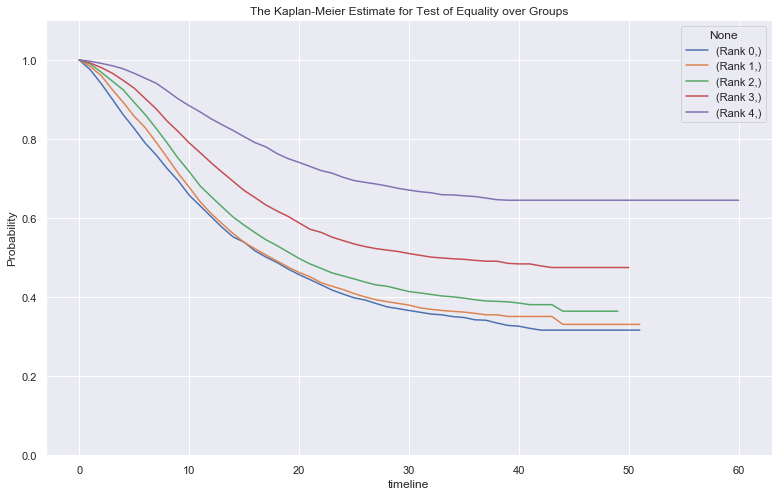

In [67]:
# plot the KM estimates
ax = plt.subplot(111)
plt.rcParams["figure.figsize"] = [13,8]

kmf.fit(T0, event_observed=C0, label=['Rank 0'])
kmf.survival_function_.plot(ax=ax)
kmf.fit(T1, event_observed=C1, label=['Rank 1'])
kmf.survival_function_.plot(ax=ax)
kmf.fit(T2, event_observed=C2, label=['Rank 2'])
kmf.survival_function_.plot(ax=ax)
kmf.fit(T3, event_observed=C3, label=['Rank 3'])
kmf.survival_function_.plot(ax=ax)
kmf.fit(T4, event_observed=C4, label=['Rank 4'])
kmf.survival_function_.plot(ax=ax)

plt.title("The Kaplan-Meier Estimate for Test of Equality over Groups")
plt.ylabel("Probability")
plt.ylim(ymax = 1.1, ymin = 0)

kmf2 = plt.gcf()

In [55]:
np.unique(lifetest2.FICO_orig_time_rank)

array([0., 1., 2., 3., 4.])

In [47]:
# survdiff: Test Survival Curve Differences
# survdiff(formula, data, subset, na.action, rho=0, timefix=TRUE)

In [48]:
# survdiff(formula = Surv(time2, default_time) ~ lifetest2$FICO_orig_time_rank,
#         data = lifetest, rho = 0)

In [49]:
# Testing difference in R 
%%R 
survdiff(Surv(time, delta) ~ type)
Call:
survdiff(formula = Surv(time, delta) ~ type)

        N Observed Expected (O-E)^2/E (O-E)^2/V
type=1 52       31     36.6     0.843      2.79
type=2 28       22     16.4     1.873      2.79

 Chisq= 2.8  on 1 degrees of freedom, p= 0.0949 

SyntaxError: invalid syntax (<ipython-input-49-3b2c9dfe176d>, line 3)

In [50]:
# Testing difference in Python
from lifelines.statistics import logrank_test
summary_= logrank_test(T, T2, C, C2, alpha=99)

print summary_

<lifelines.StatisticalResult: 
Results
   df: 1
   alpha: 99
   t 0: -1
   test: logrank
   null distribution: chi squared

   __ p-value ___|__ test statistic __|____ test result ____|__ is significant __
         0.09487 |              2.790 |  Cannot Reject Null |       False       
>


SyntaxError: Missing parentheses in call to 'print' (<ipython-input-50-a03e0e544f2f>, line 5)

In [ ]:
summary_= logrank_test(T, T2, C, C2, alpha=99)
print summary_

In [53]:
from lifelines.statistics import logrank_test
logrank_test??

In [148]:
dir(logrank_test)

['__annotations__',
 '__call__',
 '__class__',
 '__closure__',
 '__code__',
 '__defaults__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__get__',
 '__getattribute__',
 '__globals__',
 '__gt__',
 '__hash__',
 '__init__',
 '__kwdefaults__',
 '__le__',
 '__lt__',
 '__module__',
 '__name__',
 '__ne__',
 '__new__',
 '__qualname__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__']

In [151]:
dir(ll.statistics)

['KaplanMeierFitter',
 'StatisticalResult',
 'TimeTransformers',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_to_array',
 '_to_list',
 'chisq_test',
 'combinations',
 'dataframe_interpolate_at_times',
 'format_floats',
 'format_p_value',
 'group_survival_table_from_events',
 'logrank_test',
 'multivariate_logrank_test',
 'np',
 'pairwise_logrank_test',
 'pd',
 'power_under_cph',
 'print_function',
 'proportional_hazard_test',
 'sample_size_necessary_under_cph',
 'stats',
 'string_justify',
 'survival_difference_at_fixed_point_in_time_test',
 'two_sided_z_test']

In [149]:
from inspect import getsource

In [ ]:
getsource

In [152]:
from lifelines.statistics import multivariate_logrank_test
multivariate_logrank_test??

In [147]:
dir(ll)

['AalenAdditiveFitter',
 'AalenJohansenFitter',
 'BreslowFlemingHarringtonFitter',
 'CoxPHFitter',
 'CoxTimeVaryingFitter',
 'ExponentialFitter',
 'KaplanMeierFitter',
 'LogLogisticAFTFitter',
 'LogLogisticFitter',
 'LogNormalAFTFitter',
 'LogNormalFitter',
 'NelsonAalenFitter',
 'PiecewiseExponentialFitter',
 'WeibullAFTFitter',
 'WeibullFitter',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '__version__',
 'compat',
 'fitters',
 'plotting',
 'statistics',
 'utils',
 'version']

**Exhibit 7.10a**

In [59]:
lifetest2.columns

Index(['id', 'time', 'orig_time', 'first_time', 'mat_time', 'balance_time',
       'LTV_time', 'interest_rate_time', 'hpi_time', 'gdp_time', 'uer_time',
       'REtype_CO_orig_time', 'REtype_PU_orig_time', 'REtype_SF_orig_time',
       'investor_orig_time', 'balance_orig_time', 'FICO_orig_time',
       'LTV_orig_time', 'Interest_Rate_orig_time', 'hpi_orig_time',
       'default_time', 'payoff_time', 'status_time', 'time2', 'indicator',
       'FICO_orig_time_rank'],
      dtype='object')

In [60]:
lifetestb = lifetest2[['time2','default_time','FICO_orig_time','LTV_orig_time']]
lifetestb

,time2,default_time,FICO_orig_time,LTV_orig_time
23,24,1,715,69.4
25,2,0,558,80.0
30,5,0,680,83.6
65,36,0,587,81.8
68,3,0,527,80.0
99,32,1,670,80.0
101,2,0,601,95.0
102,1,0,663,90.0
115,13,1,501,80.0
120,5,1,665,80.0


Setting *rho = 1* is Peto & Peto modification of the Gehan-Wilcoxon test

In [61]:
 # Setting *rho = 1* is Peto & Peto modification of the Gehan-Wilcoxon test
 ## ----Peto & Peto modification of the Gehan-Wilcoxon test-----------------
 survdiff(formula = Surv(time2, default_time) ~ lifetest2$FICO_orig_time_rank, data = lifetest, rho = 1)
# Call:
# survdiff(formula = Surv(time2, default_time) ~ lifetest2$FICO_orig_time_rank, 
    # data = lifetest, rho = 1)

                                    # N Observed Expected (O-E)^2/E (O-E)^2/V
# lifetest2$FICO_orig_time_rank=0  9922     2776     1884     422.6     619.1
# lifetest2$FICO_orig_time_rank=1 10031     2855     2146     234.2     354.6
# lifetest2$FICO_orig_time_rank=2 10022     2702     2362      48.9      76.3
# lifetest2$FICO_orig_time_rank=3  9992     2225     2627      61.5      99.7
# lifetest2$FICO_orig_time_rank=4 10033     1391     2930     808.4    1371.6

 # Chisq= 2001  on 4 degrees of freedom, p= <2e-16 
 
 # **Exhibit 7.10b**

SyntaxError: invalid syntax (<ipython-input-61-4dc5874d2354>, line 3)

In [62]:
survdiff(formula = Surv(time2, default_time) ~ lifetest2$FICO_orig_time_rank,
         data = lifetest, rho = 1)

SyntaxError: invalid syntax (<ipython-input-62-c6d5fcb24039>, line 1)

In [63]:
kmf.fit(durations = lifetest.time2, 
        event_observed = lifetest.default_time)

<lifelines.KaplanMeierFitter: fitted with 50000 observations, 34846 censored>

**Exhibit 7.10b**

# Cox Proportional Hazards Models
## Cox Proportional Hazards Model in R Using coxph
Use function *coxph()* from library *survival* to fit a Cox Proportional Hazards model.

In [ ]:
from lifelines import CoxPHFitter
cph = CoxPHFitter()
from lifelines.datasets import load_rossi

In [ ]:
 #Cox Proportional Hazards Models
 ##Cox Proportional Hazards Model in R Using coxph
 # Use function *coxph()* from library *survival* to fit a Cox Proportional Hazards model.
 ## ----cph-----------------------------------------------------------------
 cph.model <- coxph(Surv(time2, default_time) ~ FICO_orig_time + LTV_orig_time, data = lifetest, ties = "efron")
 summary(cph.model)
# Call:
# coxph(formula = Surv(time2, default_time) ~ FICO_orig_time  
    # LTV_orig_time, data = lifetest, ties = "efron")

  # n= 50000, number of events= 15154 

                     # coef  exp(coef)   se(coef)      z Pr(>|z|)    
# FICO_orig_time -0.0044157  0.9955940  0.0001114 -39.64   <2e-16 ***
# LTV_orig_time   0.0155425  1.0156639  0.0008019  19.38   <2e-16 ***
# ---
# Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

               # exp(coef) exp(-coef) lower .95 upper .95
# FICO_orig_time    0.9956     1.0044    0.9954    0.9958
# LTV_orig_time     1.0157     0.9846    1.0141    1.0173

# Concordance= 0.63  (se = 0.003 )
# Rsquare= 0.042   (max possible= 0.998 )
# Likelihood ratio test= 2164  on 2 df,   p=<2e-16
# Wald test            = 2184  on 2 df,   p=<2e-16
# Score (logrank) test = 2199  on 2 df,   p=<2e-16

 
 # **Exhibit 7.13**

In [ ]:
 cph.model <- coxph(Surv(time2, default_time) ~ FICO_orig_time + LTV_orig_time, data = lifetest, ties = "efron")
 summary(cph.model)

**Exhibit 7.13**

In [44]:
#rossi_dataset = load_rossi()
cph = CoxPHFitter()
cph.fit(lifetestb.dropna, duration_col='time2', event_col='default_time', show_progress=True)

#cph.fit(rossi_dataset, duration_col='week', event_col='arrest', show_progress=True)
#cph.fit(lifetest.dropna, duration_col= lifetest_temp1['time2'], event_col='default_time', show_progress=True)

cph.print_summary()  # access the results using cph.summary

NameError: name 'lifetestb' is not defined

In [104]:
T = lifetestb['default_time'].values #duration column
E = lifetestb['time2'].values # event column

In [99]:
cph = CoxPHFitter()
cph.fit(lifetestb, 'T', 'E', cluster_col='LTV_orig_time')
cph.print_summary()

KeyError: 'T'

In [87]:
from lifelines.estimation import NelsonAalenFitter

naf = NelsonAalenFitter()

In [89]:
naf.fit(T)

<lifelines.NelsonAalenFitter: fitted with 50000 observations, 0 censored>

          NA_estimate
timeline             
0.0          1.193735
1.0         11.397004


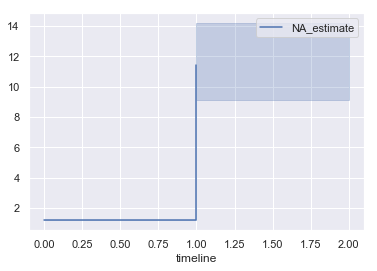

In [91]:
print (naf.cumulative_hazard_.head())
naf.plot()

In [92]:
# from lifelines import CoxPHFitter

df = pd.DataFrame({
    'T': [5, 3, 9, 8, 7, 4, 4, 3, 2, 5, 6, 7],
    'E': [1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0],
    'month': [10, 3, 9, 8, 7, 4, 4, 3, 2, 5, 6, 7],
    'age': [4, 3, 9, 8, 7, 4, 4, 3, 2, 5, 6, 7],
    'id': [1, 1, 1, 1, 2, 3, 3, 4, 4, 5, 6, 7]
})

# cph = CoxPHFitter()
cph.fit(df, 'T', 'E', cluster_col='id')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 12 observations, 3 censored>
      duration col = 'T'
         event col = 'E'
       cluster col = 'id'
   robust variance = True
number of subjects = 12
  number of events = 9
    log-likelihood = -2.77
  time fit was run = 2019-03-01 05:12:39 UTC

---
        coef  exp(coef)  se(coef)      z      p  -log2(p)  lower 0.95  upper 0.95
month  -3.13       0.04      0.10 -29.92 <0.005    650.87       -3.33       -2.92
age   -15.63       0.00      0.23 -68.05 <0.005       inf      -16.08      -15.18
---
Concordance = 0.97
Likelihood ratio test = 23.47 on 2 df, -log2(p)=16.93


C:\ProgramData\Anaconda3\lib\site-packages\lifelines\fitters\coxph_fitter.py:527: ConvergenceWarning: Newton-Rhapson convergence completed but norm(delta) is still high, 1.890. This may imply non-unique solutions to the maximum likelihood. Perhaps there is colinearity or complete separation in the dataset?
  ConvergenceWarning,


Use new data sets to generate two survival curves by using function *survfit()*. Then, plot them.

In [ ]:
curve.high = survfit(cph.model, newdata = data.frame(FICO_orig_time = 600, LTV_orig_time = 90), conf.type = "none")
curve.low = survfit(cph.model, newdata = data.frame(FICO_orig_time = 800, LTV_orig_time = 60), conf.type = "none")

In [ ]:
plot(curve.high, xlim = c(0, 45), xlab = "time2", main = "Survivor Functions", ylab = "Survival Probability", lty = 1)
 lines(curve.low, lty = 2, add = TRUE)
 legend(x = "bottom", bty = "n", cex=0.8, legend = c("high", "low"), lty = 1:2, lwd = 1, horiz = TRUE)

In [ ]:
# print many lines together 

#f2 = tongue.type==2
#T2 = tongue[f2]['time']
#C2 = tongue[f2]['delta']

#ax = plt.subplot(111)

#kmf.fit(T, event_observed=C, label=['Type 1 DNA'])
#kmf.survival_function_.plot(ax=ax)
#kmf.fit(T2, event_observed=C2, label=['Type 2 DNA'])
#kmf.survival_function_.plot(ax=ax)

#plt.title('Lifespans of different tumor DNA profile')

#kmf2 = plt.gcf()

*Exhibit 7.14**

## Time-Varying Covariates: Aggregation of Time-Varying Information
Create a new copy of the data set *mortgage* with name as *moment*. Then sort it by *id* with descending order and remove rows with duplicated *id*. Afterwards, select 3 variables (columns) and rename them.

In [ ]:
 moment <- mortgage
 moment <- moment[order(moment$id, decreasing = TRUE), ]
 moment <- moment[!duplicated(moment$id), ]
 
 moment <- subset(moment, select = c("id", "LTV_time", "gdp_time"))
 colnames(moment) <- c("id", "LTV", "gdp")

Sort the data set *lifetest* by *id* and then merge it with *moment* to form a new data set *lifetest2*.

In [ ]:
 lifetest <- lifetest[order(lifetest$id), ]
 lifetest2 <- merge(lifetest, moment)

Use *lifetest2* to fit a Cox Proportional Hazards model by using function *coxph()*.

In [ ]:
 cph.model <- coxph(Surv(time2, default_time) ~ FICO_orig_time + LTV + gdp, data = lifetest2, ties = "efron")
 summary(cph.model)

**Exhibit 7.15**

## Time-Varying Covariates: Counting Process Data
Create a new copy of the data set *mortgage* with name as *phreg*. Generate *time1* and *time2*.

In [ ]:
 phreg <- mortgage
 phreg$time1 <- phreg$time - phreg$first_time
 phreg$time2 <- phreg$time - phreg$first_time + 1

Extract a sample from *phreg* with specific *id*.

In [ ]:
 variables <- c("id", "first_time", "time", "time1", "time2", "default_time", "payoff_time", "FICO_orig_time", "LTV_orig_time", "LTV_time", "gdp_time")
 id46 <- phreg[which(phreg$id == 46 & phreg$time %in% c(27:29)), variables]
 id47 <- phreg[which(phreg$id == 47 & phreg$time %in% c(25:27)), variables]
 id56 <- phreg[which(phreg$id == 56 & phreg$time %in% c(58:60)), variables]
 print(rbind(id46, id47, id56))

**Exhibit 7.16**

Fit a Cox Proportional Hazards model using data set *phreg*.

In [ ]:
 cph.model <- coxph(Surv(time1, time2, default_time) ~ FICO_orig_time + LTV_time + gdp_time, data = phreg, ties = "efron")
 summary(cph.model)

**Exhibit 7.17**

Generate survival curves with new inputted data and plot them.

In [ ]:
 curve.downturn <- survfit(cph.model, newdata = data.frame(FICO_orig_time = 800, LTV_time = 60, gdp_time = -3),conf.type = "none")
 curve.upturn <- survfit(cph.model, newdata = data.frame(FICO_orig_time = 800, LTV_time = 60, gdp_time = 3), conf.type = "none")
 

In [ ]:
 plot(curve.downturn, xlim = c(0, 45), xlab = "time2", main = "Survivor Functions", ylab = "Survival Probability",lty = 1)
 lines(curve.upturn, lty = 2, add = TRUE)
 legend(x = "bottom", bty = "n", cex=0.8, legend = c("downturn", "upturn"), lty = 1:2, lwd = 1, horiz = TRUE)

**Exhibit 7.18**

# Accelerated Failure Time Models
## Graphical Procedures
Similar to previous procudure, generate a life table from the data set *lifetest* and retrieve survival probabilities from it.

In [ ]:
 tis <- c(seq(0, 102, 1), Inf)
 ninit <- nrow(lifetest)
 nlost <- numeric()
 
 for (i in 1:length(tis)-1){
 nlost[i] <- as.numeric(nrow(lifetest[lifetest$time2 >= tis[i] & lifetest$time2 < tis[i+1] & lifetest$default_time == 0, ]))
 }

In [ ]:
 nevent <- numeric()
 for (i in 1:length(tis)-1){
  nevent[i] <- as.numeric(nrow(lifetest[lifetest$time2 >= tis[i] & lifetest$time2 < tis[i+1] & lifetest$default_time == 1, ]))
 }
 

In [ ]:
 LifeTable = lifetab(tis, ninit, nlost, nevent)
 SURVIVAL = LifeTable['surv'].values

Plot the negative log of the survival curve.

In [ ]:
 plot(-log(SURVIVAL), type = "o", main = "Negative Log of Estimated Survivor Function",
      xlim = c(0, 60), xlab = "time2",
      ylab = "-log(Survival Probability)")

**Exhibit 7.20**

Plot the log of the negative log of the survival curve.

In [ ]:
plot(log(-log(SURVIVAL)) ~ log(1:as.numeric(length(SURVIVAL))), type = "o", main = "Log of Negative Log of Estimated Survivor Function",
         xlab = "log(time2)",
         ylab ="log[-log(Survuval Probability)]")

**Exhibit 7.21**

## Accelerated Failure Time Models with survreg
Fit the survival regression using function *survreg()*.

In [ ]:
 lifereg <- survreg(Surv(time2, default_time) ~ FICO_orig_time + LTV_orig_time, data = lifetest, dist = "exponential")
 summary(lifereg)

**Exhibit 7.23**

## Calibration of AFT Models: Comparison of Default Indicators and Estimated Default Probabilities
Use function *predict()* to compute the linear predictors from the fitted model *lifereg*. Then compute the estimated default probabilities and compare it with the observed one.

In [ ]:
 xbeta <- predict(lifereg,type="lp")

In [ ]:
 lambda <- exp(-xbeta)

In [ ]:
 S1 <- 1 - pexp(phreg$time1, rate = lambda)

In [ ]:
 S2 <- 1 - pexp(phreg$time2, rate = lambda)

In [ ]:
 PD_time <- (S1-S2)/S1

In [ ]:
 mean(phreg$default_time, na.rm = TRUE)

In [ ]:
 mean(PD_time, na.rm = TRUE)

**Exhibit 7.24**